# 模型选择、欠拟合和过拟合

通过多项式拟合来探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

查看一下前2个样本

In [3]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.6221],
         [-2.0852]]),
 tensor([[ 1.0000e+00, -6.2210e-01,  1.9350e-01, -4.0126e-02,  6.2405e-03,
          -7.7644e-04,  8.0503e-05, -7.1544e-06,  5.5634e-07, -3.8455e-08,
           2.3923e-09, -1.3529e-10,  7.0138e-12, -3.3563e-13,  1.4914e-14,
          -6.1853e-16,  2.4049e-17, -8.8005e-19,  3.0415e-20, -9.9586e-22],
         [ 1.0000e+00, -2.0852e+00,  2.1740e+00, -1.5110e+00,  7.8769e-01,
          -3.2849e-01,  1.1416e-01, -3.4006e-02,  8.8637e-03, -2.0536e-03,
           4.2821e-04, -8.1171e-05,  1.4105e-05, -2.2624e-06,  3.3696e-07,
          -4.6841e-08,  6.1045e-09, -7.4876e-10,  8.6738e-11, -9.5192e-12]]),
 tensor([  3.3008, -13.4165]))

实现一个函数来评估模型在给定数据集上的损失

In [4]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正常)

weight: [[ 4.990259   1.2448083 -3.4207015  5.508372 ]]


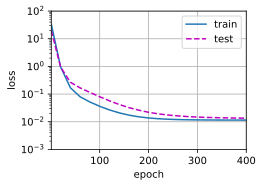

In [6]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[2.7055626 5.0757246]]


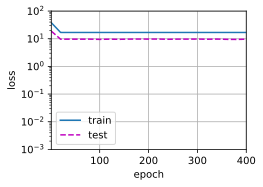

In [7]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.9756694   1.3182484  -3.3447752   5.211159   -0.30390823  0.582732
   0.3212628  -0.3401418   0.28297633 -0.0172802   0.05458953  0.01645943
  -0.18254404  0.2210972   0.12245058  0.02651333 -0.11819229 -0.10687704
   0.01260356 -0.03873312]]


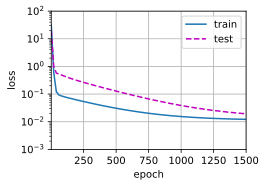

In [8]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)